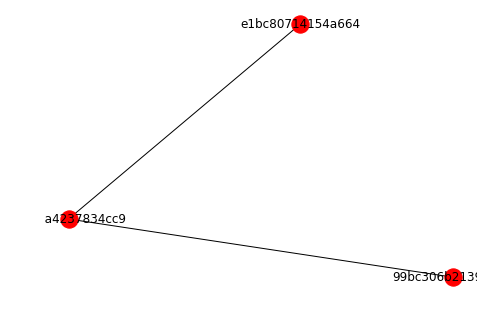

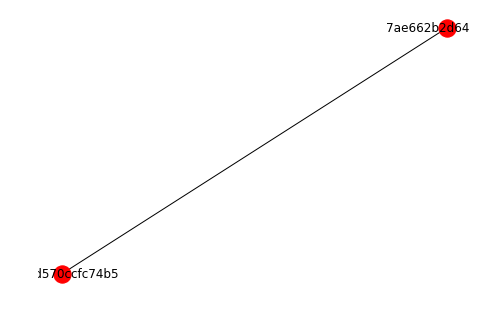

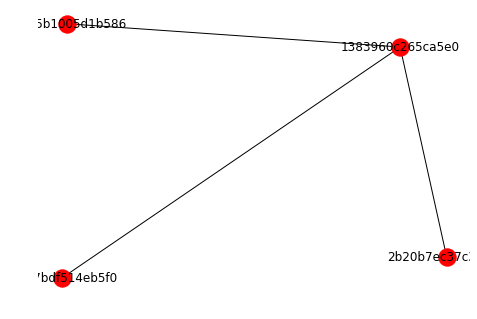

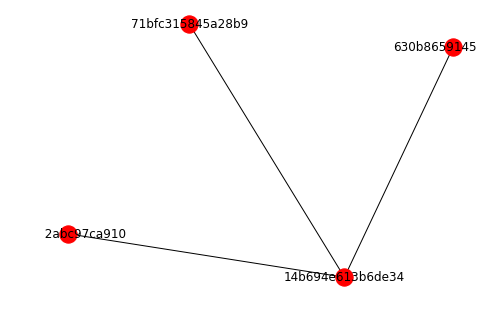

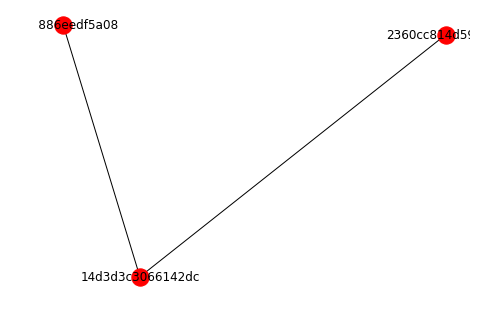

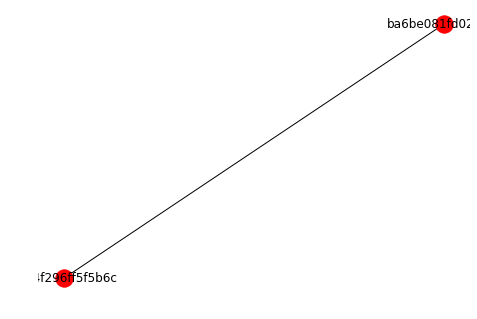

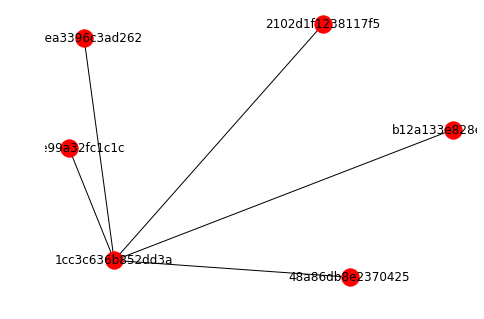

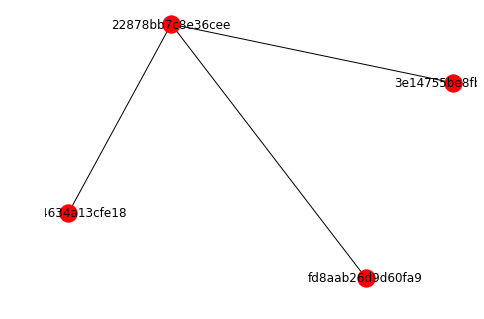

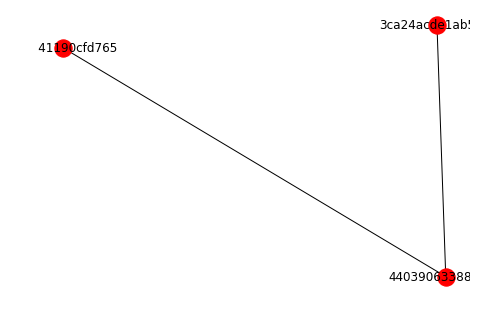

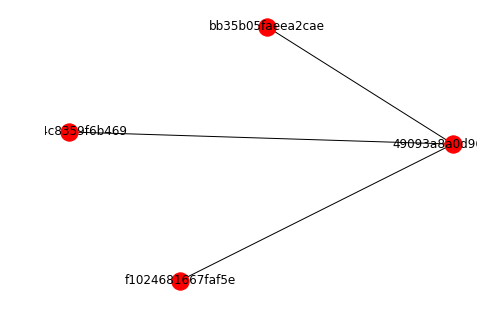

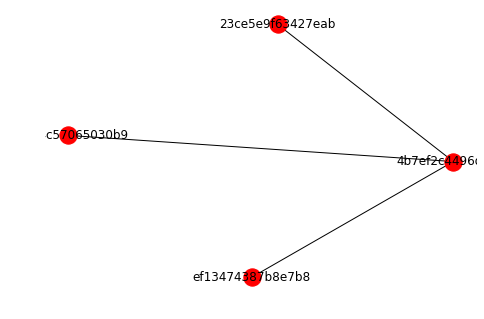

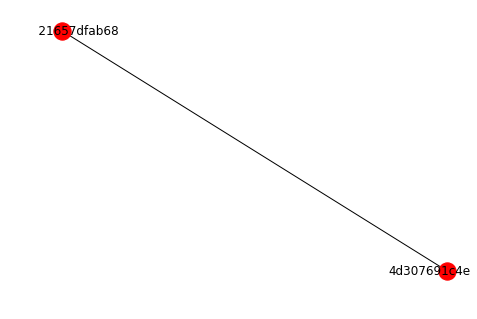

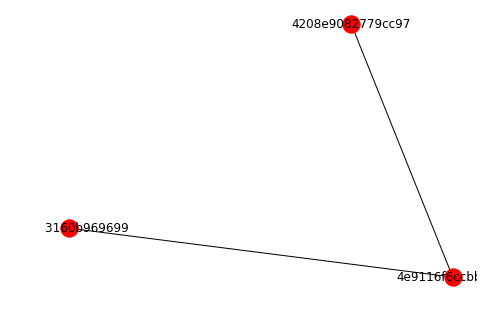

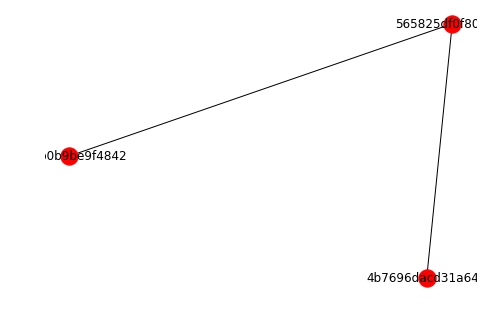

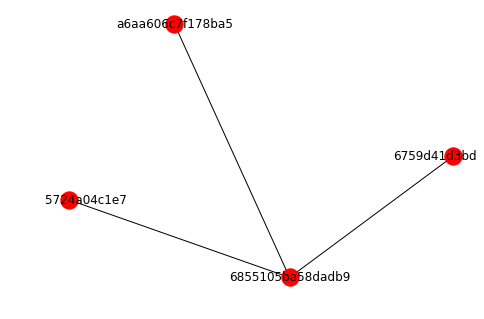

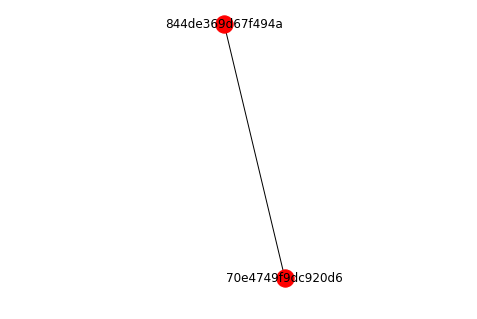

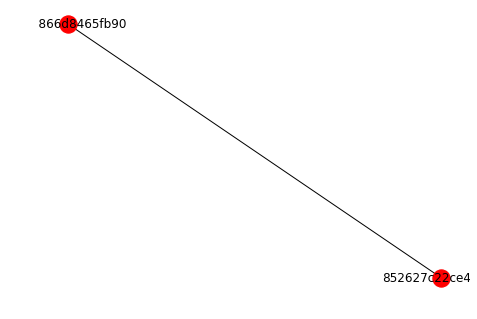

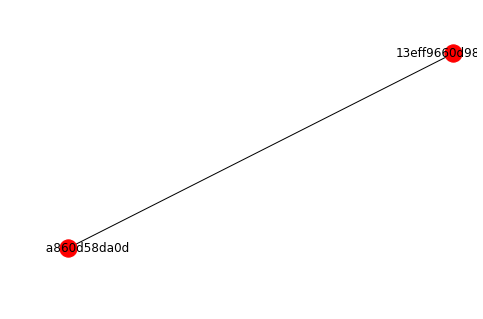

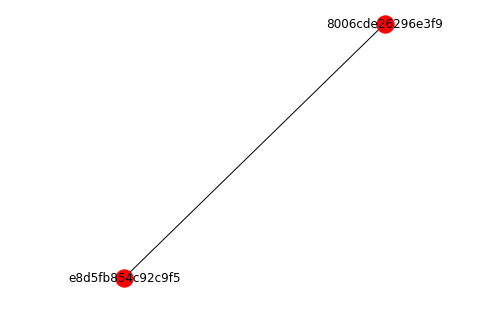

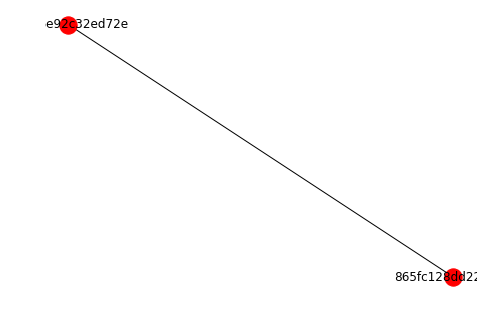

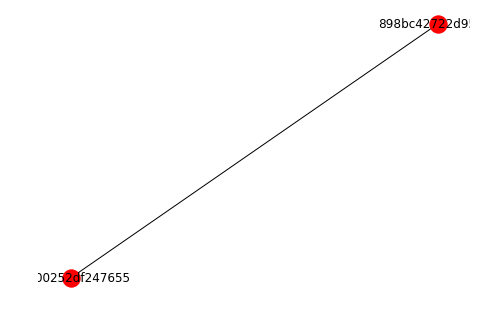

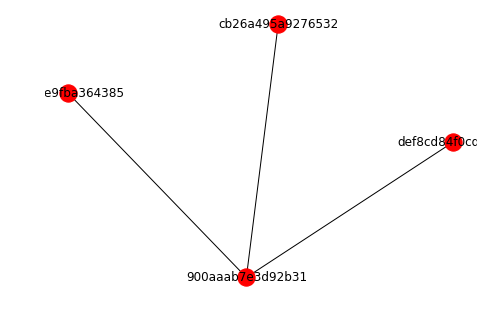

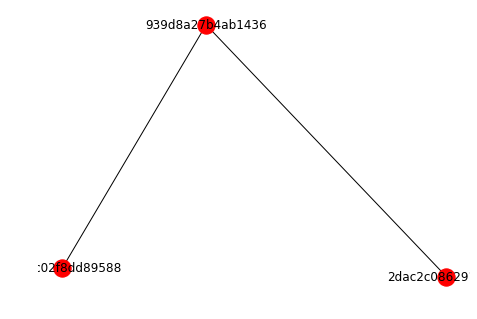

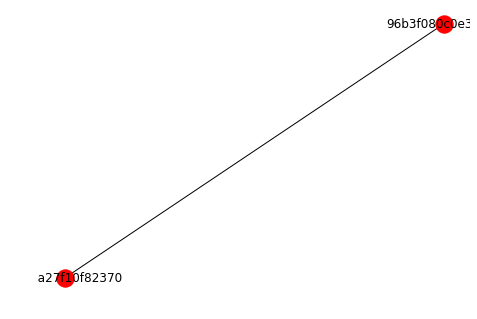

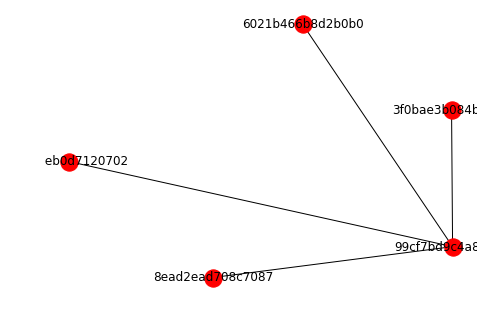

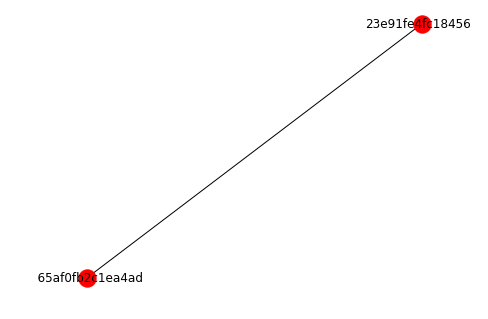

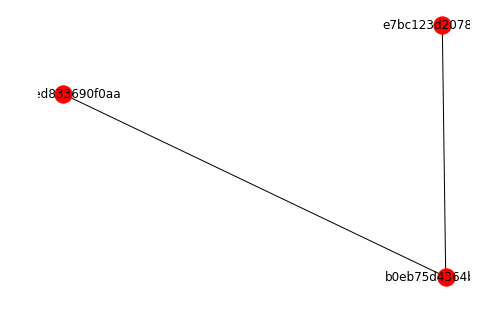

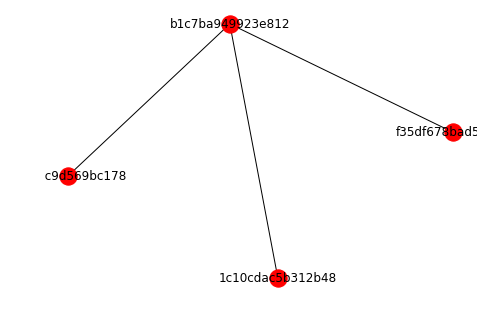

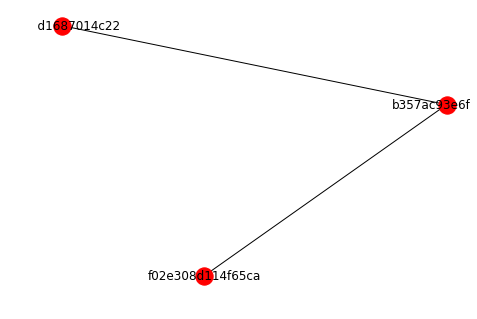

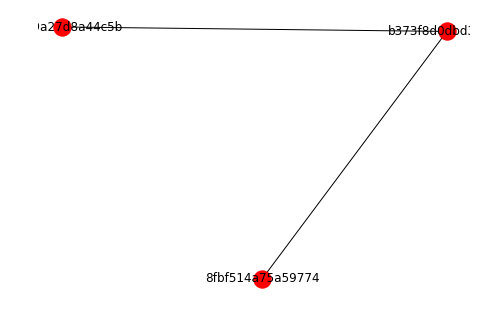

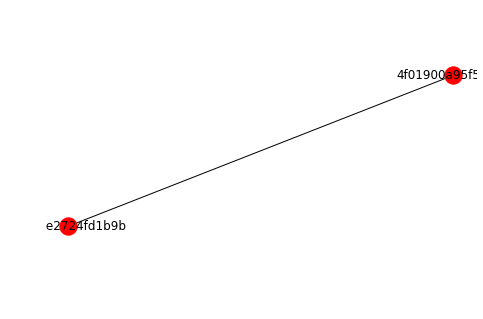

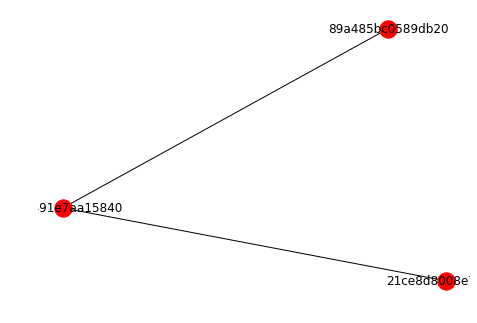

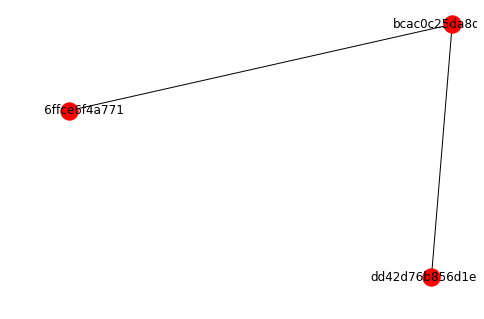

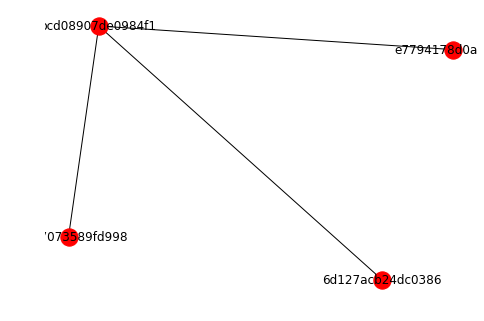

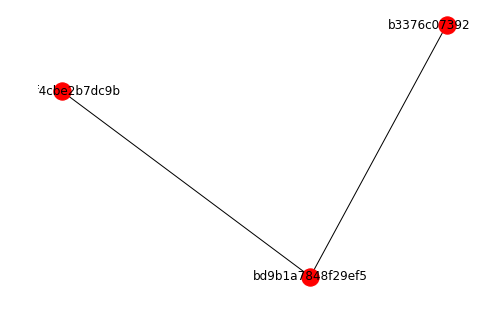

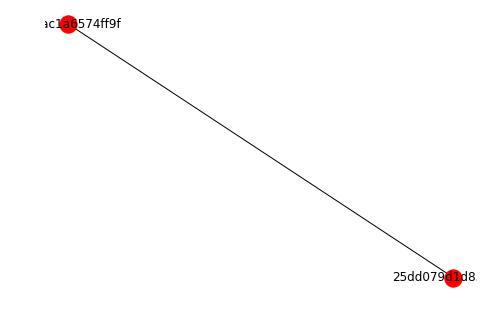

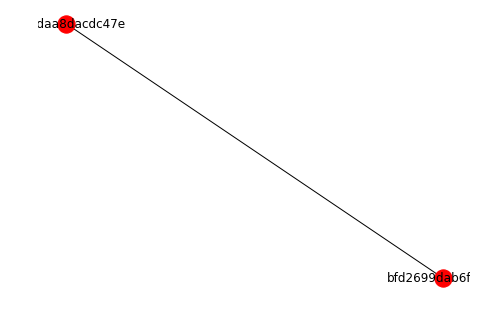

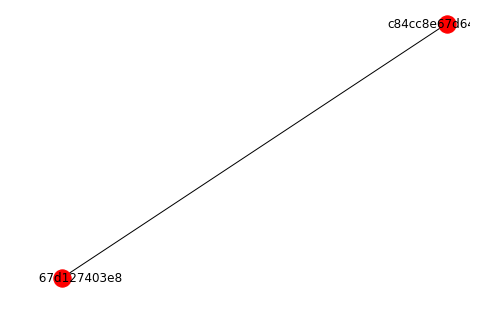

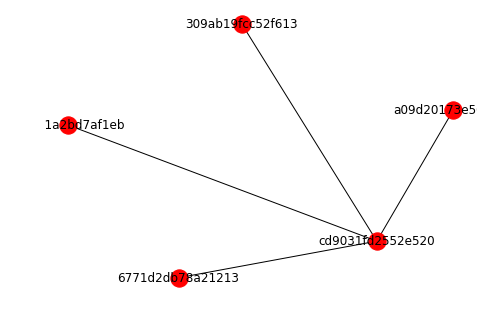

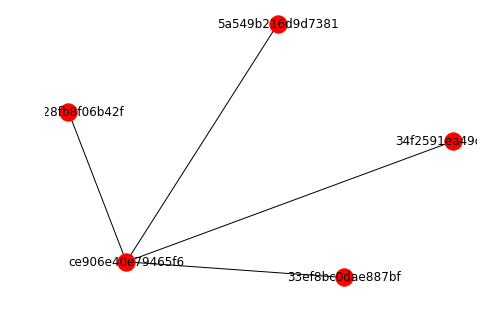

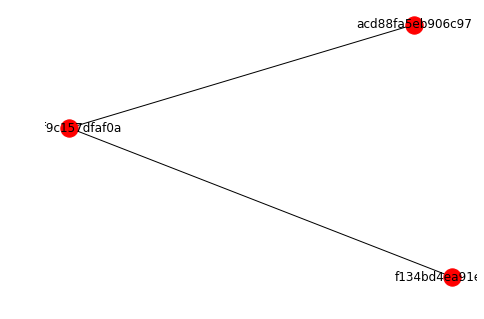

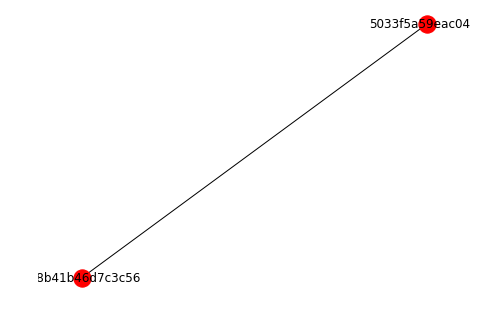

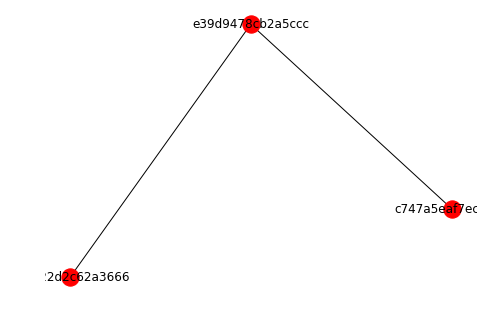

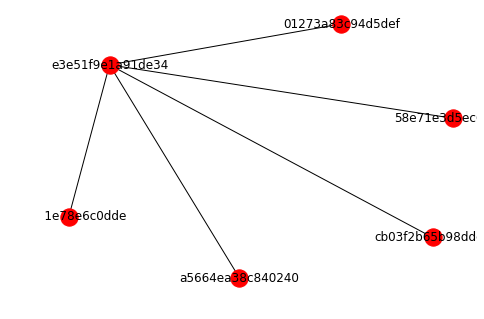

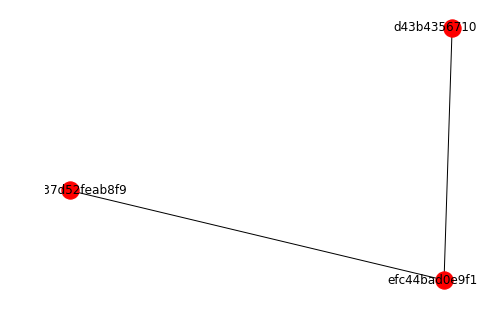

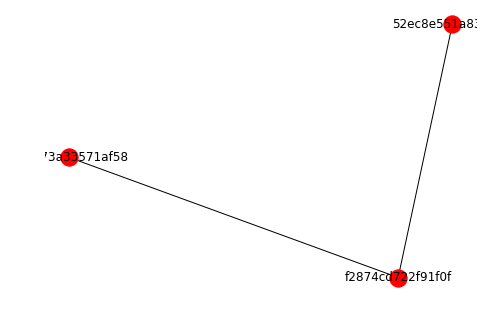

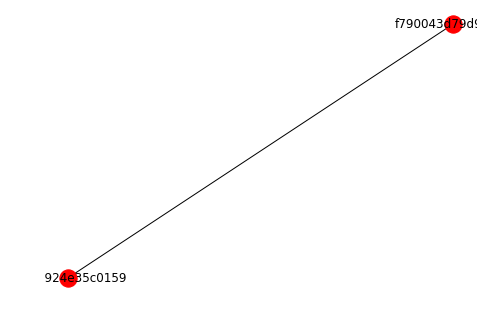

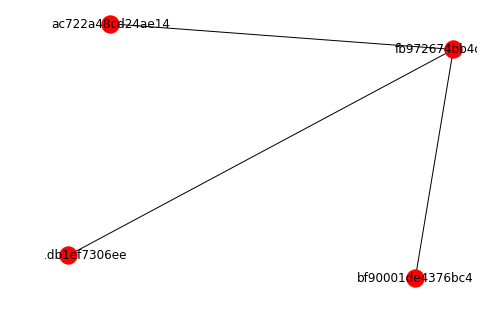

Communities with local maximal modularity:
Modularity:
0.9641701793941745
Communities:
[{'99bc306b21393623', 'e1bc80714154a664', '0616fa4237834cc9'}, {'07abd570ccfc74b5', '7ae662b2d6463366'}, {'1383960c265ca5e0', '2b20b7ec37c361e4', '9f637bdf514eb5f0', 'd60c5b1005d1b586'}, {'e8f282abc97ca910', '71bfc315845a28b9', '630b86591457c9aa', '14b694e613b6de34'}, {'14d3d3c3066142dc', 'fa3f3886eedf5a08', '2360cc814d591ad5'}, {'1a74f296ff5f5b6c', 'ba6be081fd0271f2'}, {'1cc3c636b852dd3a', 'b12a133e828edaa6', '8dfea3396c3ad262', '2102d1f1238117f5', '48a86db8e2370425'}, {'7f32e99a32fc1c1c'}, {'fd8aab26d9d60fa9', '04564634a13cfe18', '22878bb7c8e36cee', '3e14755be8fb6d2b'}, {'440390633883f4fd', 'f9f9041190cfd765', '3ca24acde1ab5fa4'}, {'967e4c8359f6b469', '49093a8a0d960372', 'f1024681667faf5e', 'bb35b05faeea2cae'}, {'ef13474387b8e7b8', '23ce5e9f63427eab', '4b7ef2c4496de7fd', '1db94c57065030b9'}, {'efa2221657dfab68', '4d307691c4e1df21'}, {'4e9116f6ccbb0ef9', '4208e9082779cc97', '1960b3160b969699'}, {'56

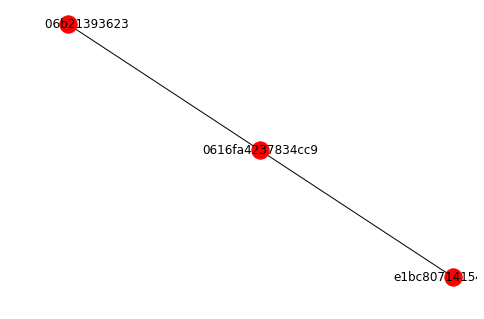

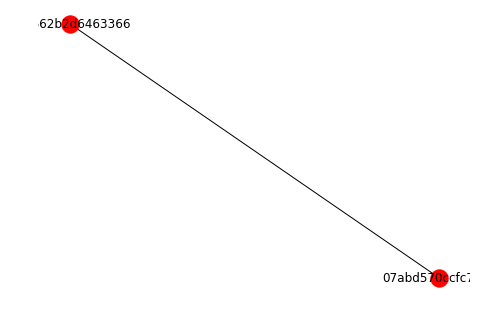

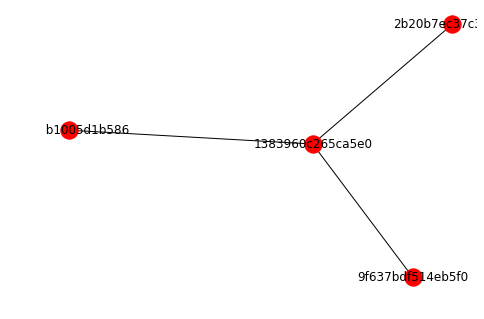

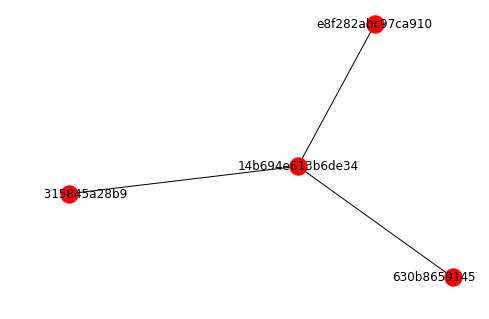

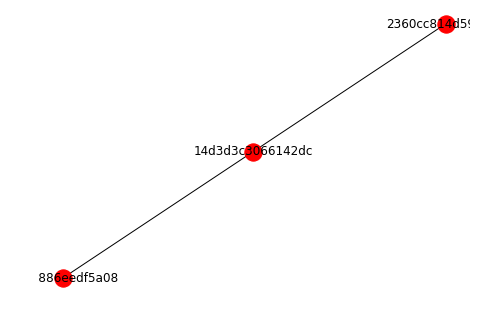

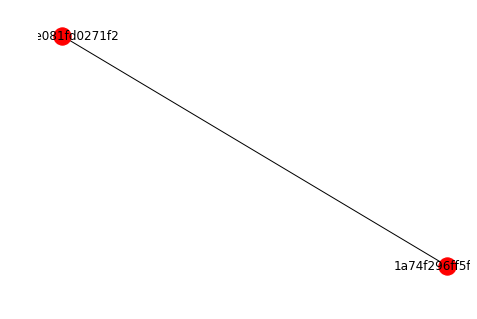

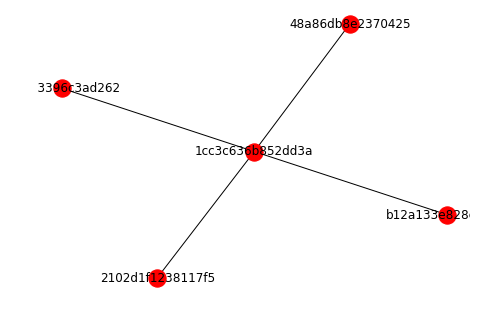

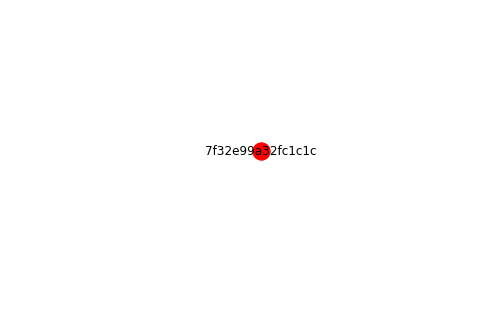

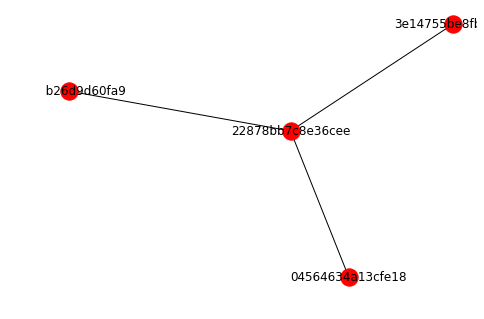

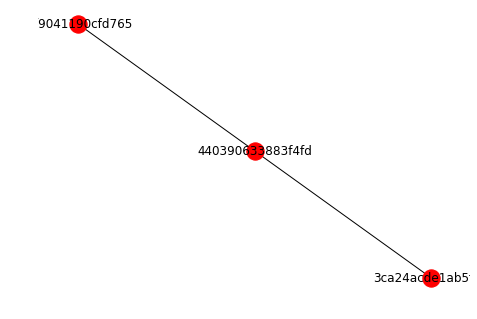

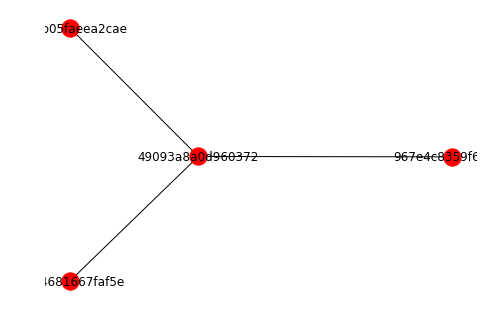

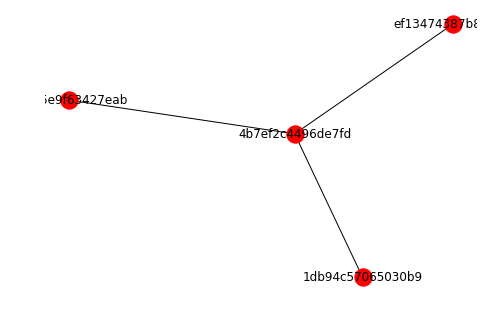

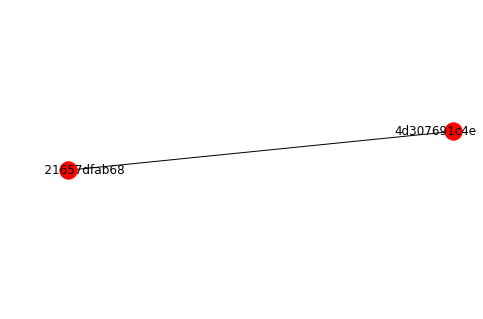

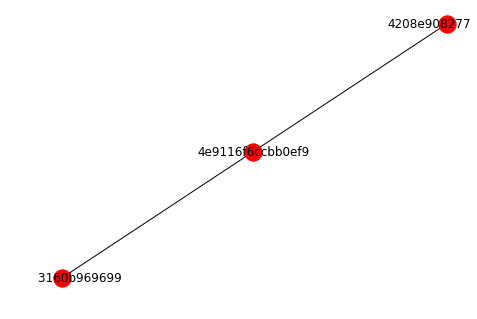

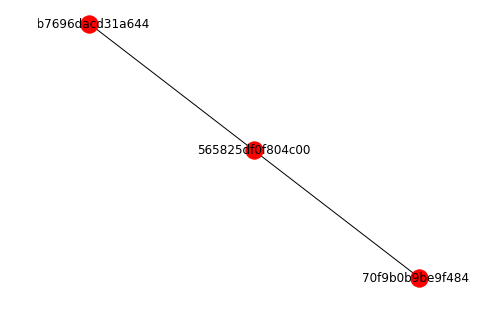

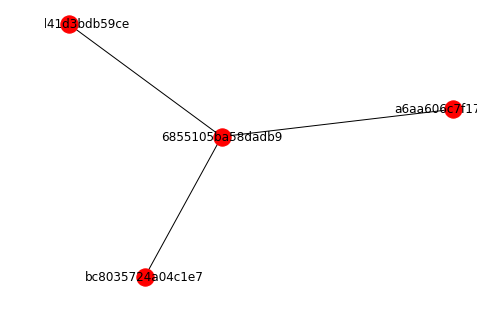

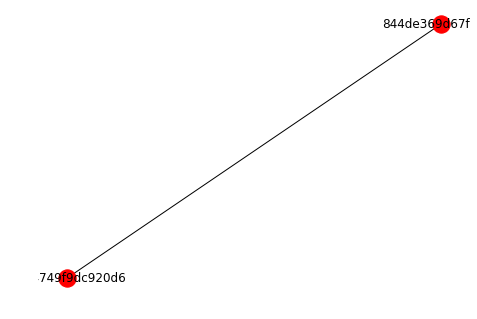

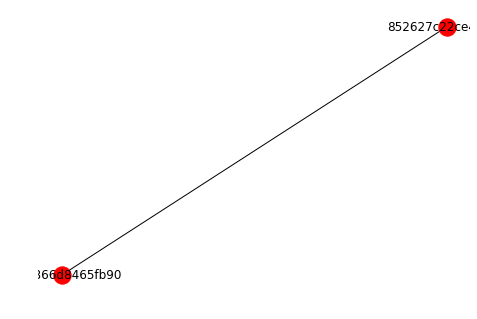

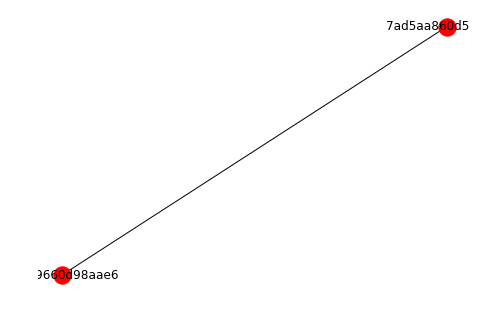

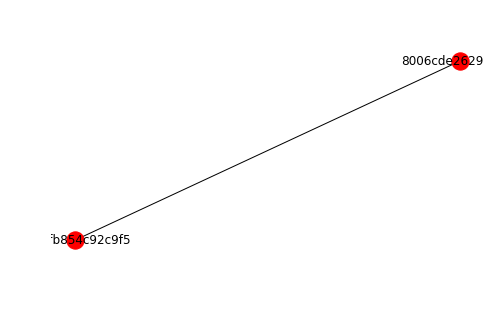

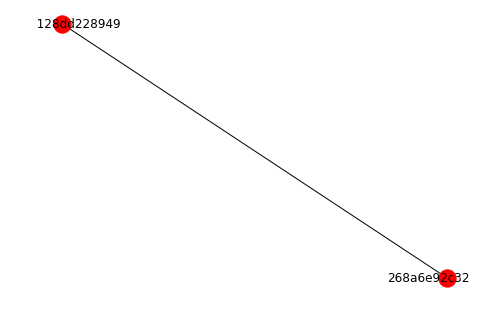

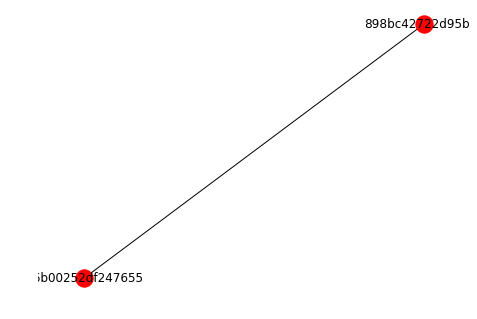

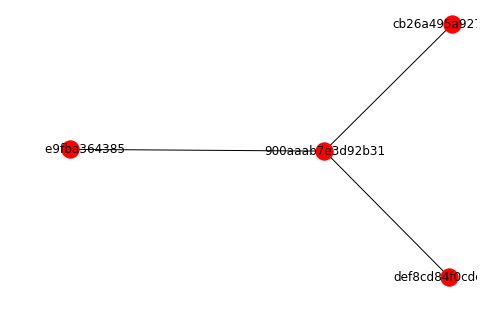

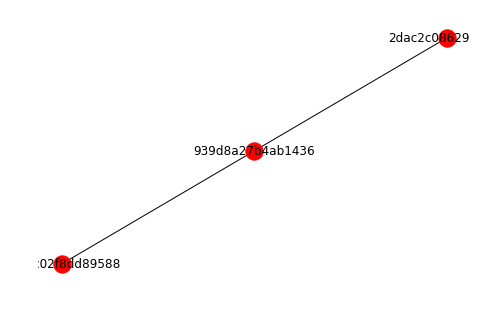

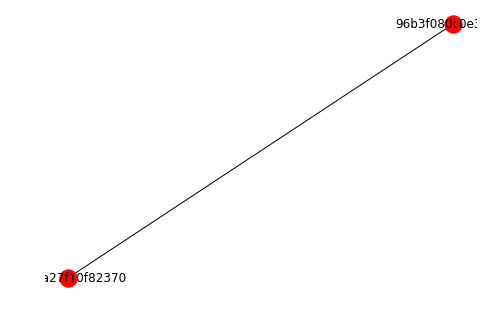

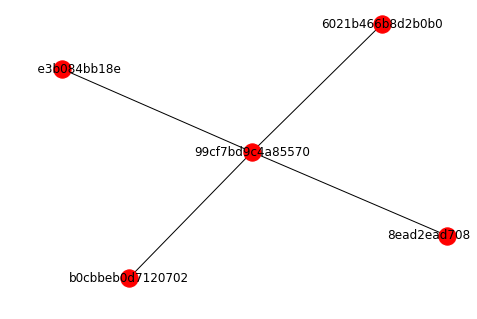

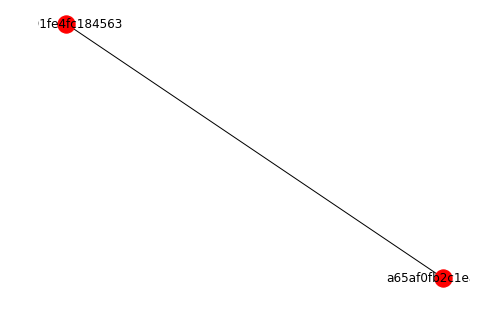

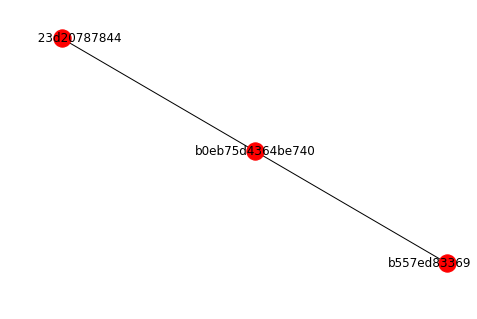

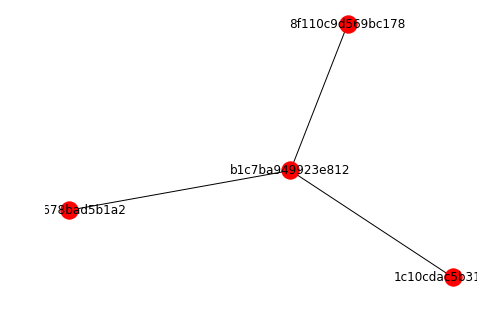

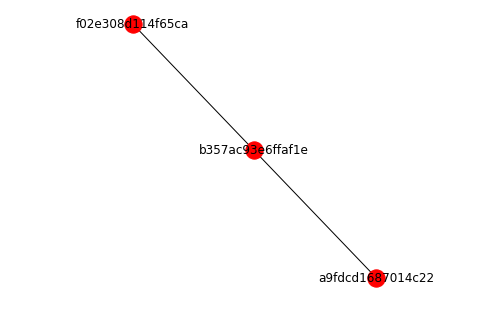

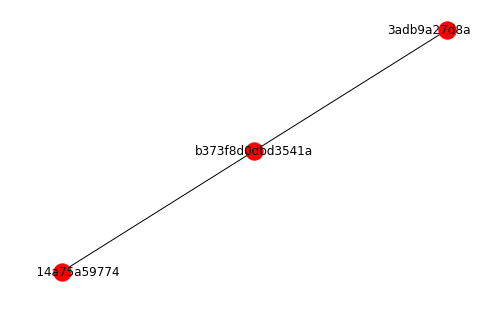

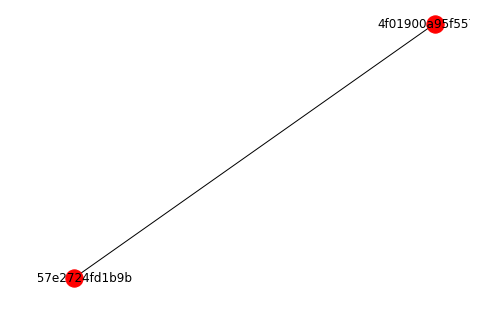

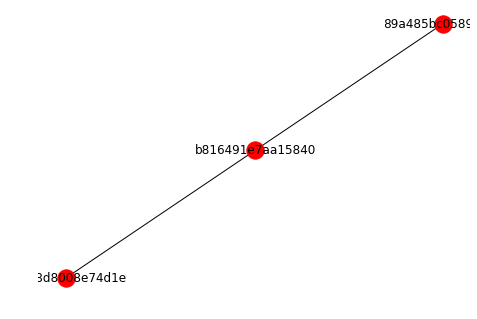

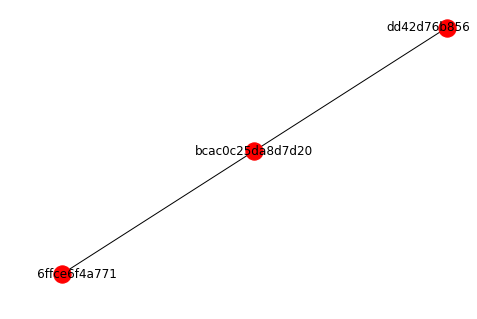

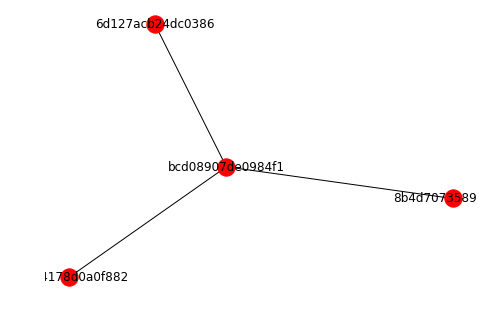

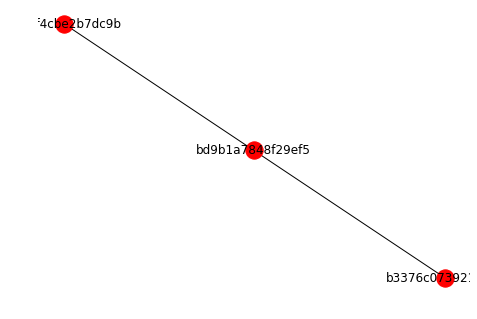

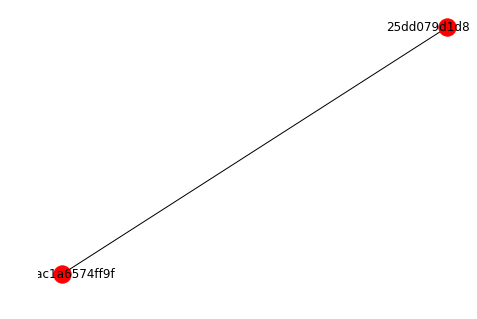

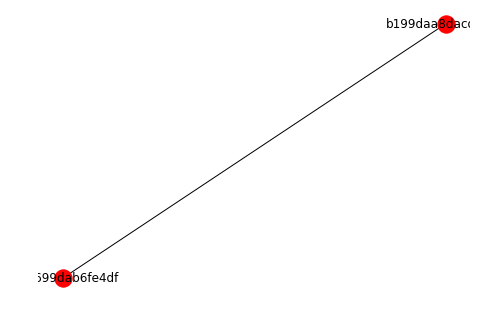

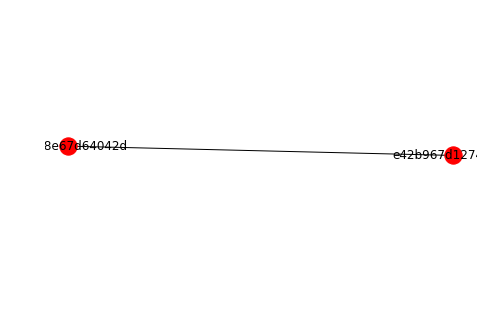

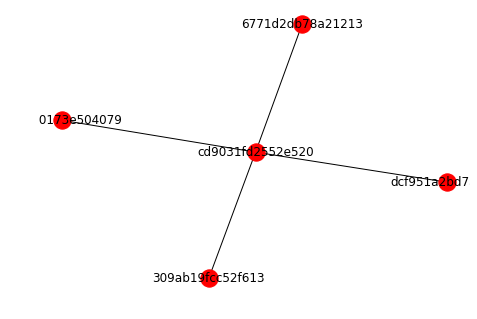

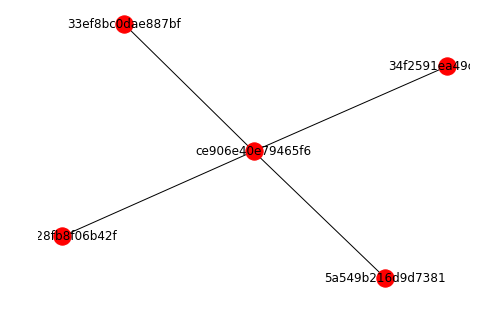

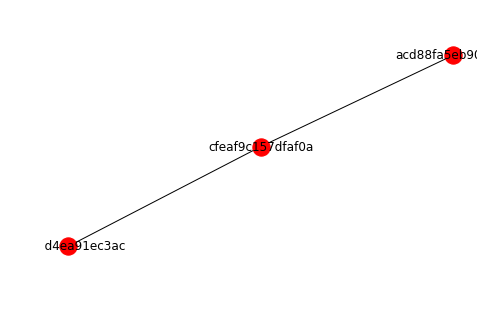

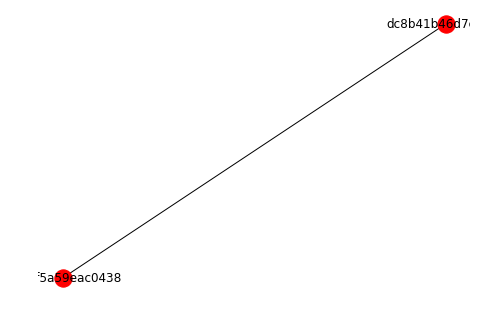

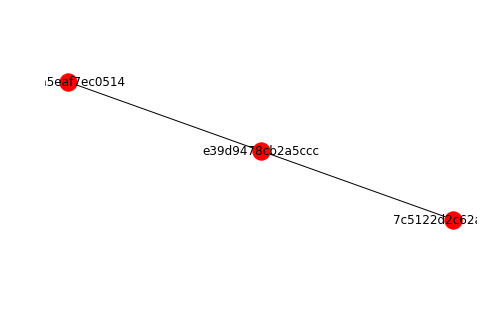

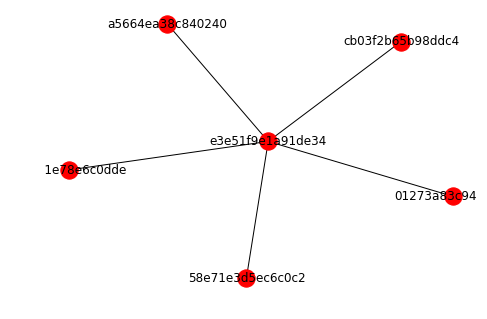

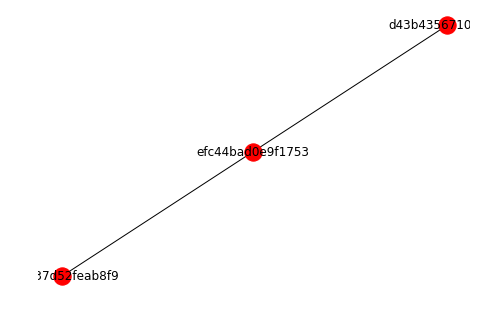

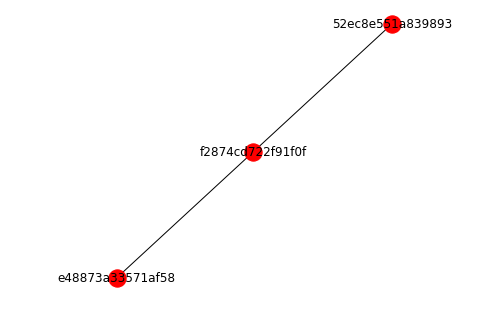

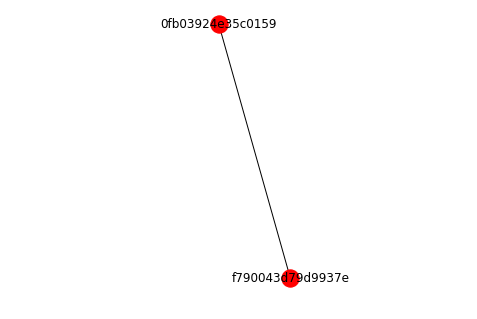

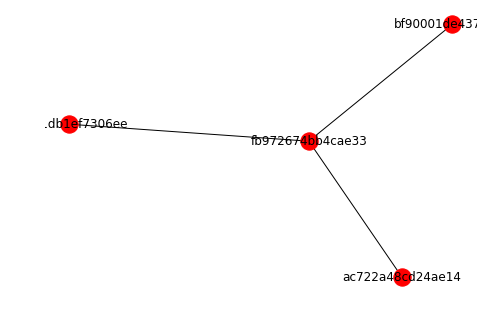

In [158]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy.signal import find_peaks

#read graph from txt file
def readGraphFrom(file):
    G = nx.read_edgelist(file, create_using=nx.Graph(), nodetype=str, data=(('og_weight', float),))
    return G

def _partialEdgeBetweenness(G):
    #create graph to store partial edge betweenness
    NG = G.copy()
    #choose each node as root once
    for root in G:
        #create ShortestPathGraph
        SPG = nx.Graph()
        #calculate shotest path from each node to root and add edges to SPG
        for vertex in G:
            for shortest_path in nx.all_shortest_paths(G, source=vertex, target=root, weight='og_weight'):
                SPG.add_path(shortest_path)
        
        #copy distances from original graph to shortest path graph
        for edge in SPG.edges:
            SPG.edges[edge]["og_weight"] = G.edges[edge]["og_weight"]
                    
        #calculate distance and weight for each node in SPG
        max_distance = 0
        for node in SPG:
            if node == root:
                SPG.nodes[node]['distance'] = 0
                SPG.nodes[node]['weight'] = 1
            else:
                #distance = nx.shortest_path_length(SPG, source=root, target=node, weight='og_weight')
                distance = nx.shortest_path_length(SPG, source=root, target=node, weight='og_weight')
                #compute maximal distance from root (needed in later steps)
                if distance > max_distance:
                    max_distance = distance
                SPG.nodes[node]['distance'] = distance
                SPG.nodes[node]['weight'] = len(list(nx.all_shortest_paths(SPG, source=root, target=node, weight='og_weight')))
                
        #calculate partial betweenness scores for leaf edges
        for leaf in SPG:
            if SPG.nodes[leaf]['distance'] == max_distance:
                for node1, node2 in SPG.edges(leaf):
                    if node1 == leaf:
                        neighbor = node2
                    else:
                        neighbor = node1
                    SPG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
                    NG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
        
        #calculate partial betweenness scores for all other edges by decreasing maximal distance in each iteration
        while max_distance > 1:
            max_distance = max_distance-1
            for node in SPG:
                #only look at nodes at the current distance level
                if SPG.nodes[node]['distance'] == max_distance:
                    for node1, node2 in SPG.edges(node):
                        if node1 == node:
                            neighborUP = node2
                        else:
                            neighborUP = node1
                        if SPG.nodes[neighborUP]['distance'] <= max_distance - 1:
                            sum_of_scores = 0
                            for node11, node22 in SPG.edges(node):
                                if node11 == node:
                                    neighborDOWN = node22
                                else:
                                    neighborDOWN = node11
                                if SPG.nodes[neighborDOWN]['distance'] >= max_distance + 1:
                                    sum_of_scores = sum_of_scores + SPG.edges[neighborDOWN, node][root]
                            #set score for edge from current distance level to one level above (root is at top)
                            SPG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            NG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            
    return NG

#calculate edge betweenness for graph
def edgeBetweenness(G, node1, node2):
    NG = G.copy()
    
    for component in nx.connected_component_subgraphs(NG):
        #recalculate betweenness scores for graph components that contain at least one of the nodes from the last
        #removed edge
        if component.has_node(node1) or component.has_node(node2) or (node1 == 0 and node2 == 0):
            SPG = _partialEdgeBetweenness(component)
            
            for edge in SPG.edges:
                SPG.edges[edge]['weight'] = 0
                for root in SPG:
                    if root in SPG.edges[edge]:
                        SPG.edges[edge]['weight'] = SPG.edges[edge]['weight'] + SPG.edges[edge][root]
                        
            #copy final scores to new graph
            for edge in SPG.edges:
                NG.edges[edge]['weight'] = SPG.edges[edge]['weight']

    return NG

#determine edge with maximal betweenness score
def maxScoreEdge(G):
    maxScore = 0.0
    for edge in G.edges:
        if maxScore < G.edges[edge]['weight']:
            maxScore = G.edges[edge]['weight']
            edgeRemove = edge
    return edgeRemove

#remove edge from graph
def removeEdge(edge, G):
    G.remove_edge(edge[0], edge[1])
    return G



G = readGraphFrom("graph.txt")
#G = nx.karate_club_graph()

for edge in G.edges:
    G.edges[edge]['weight'] = 0
    #G.edges[edge]['og_weight'] = 1

for component in nx.connected_component_subgraphs(G):
    nx.draw(component, with_labels=True)
    plt.show()
    
Graphs = [G]
Mod = [nx.algorithms.community.modularity(G, list(nx.connected_components(G)), weight='og_weight')]

num_iter = len(G.edges)
e = (0, 0)
NG = G.copy()

#iterate as many times as there are edges in the graph
while num_iter > 0:
    num_iter = num_iter - 1
    #calculate edge betweenness and store values in new graph 
    NG = edgeBetweenness(NG, e[0], e[1])
    e = maxScoreEdge(NG)
    removeEdge(e, NG)
    
    #add graph and modularity to list
    Graphs.append(NG)
    Mod.append(nx.algorithms.community.modularity(G, list(nx.connected_components(NG)), weight='og_weight'))
        
#for g in Graphs:
#    print("Components:")
#    print(list(nx.connected_components(g)))
#    print(g.edges)
               
#for mod in Mod:
#    print("Modularity:")
#    print(mod)
    
print("Communities with local maximal modularity:")

#find local maxima in modularity array
index_max_mod_np, _ = find_peaks(Mod)
index_max_mod = index_max_mod_np.tolist()

if not index_max_mod:
#    index_max_mod.append(0)
    index_max_mod.append(1)

#print modularity and communities for local maxima
for i in index_max_mod:
    print("Modularity:")
    print(Mod[i])
    print("Communities:")
    print(list(nx.connected_components(Graphs[i])))
    for component in nx.connected_component_subgraphs(Graphs[i]):
        nx.draw(component, with_labels=True)
        plt.show()

In [159]:
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight='og_weight')
    #print("max centrality")
    #print(max(centrality, key=centrality.get))
    return max(centrality, key=centrality.get)

#comp = nx.community.girvan_newman(G)
#print(tuple(sorted(c) for c in next(comp)))

comp = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge)
print(tuple(sorted(c) for c in next(comp)))

(['0616fa4237834cc9', '99bc306b21393623', 'e1bc80714154a664'], ['07abd570ccfc74b5', '7ae662b2d6463366'], ['1383960c265ca5e0', '2b20b7ec37c361e4', '9f637bdf514eb5f0', 'd60c5b1005d1b586'], ['14b694e613b6de34', '630b86591457c9aa', '71bfc315845a28b9', 'e8f282abc97ca910'], ['14d3d3c3066142dc', '2360cc814d591ad5', 'fa3f3886eedf5a08'], ['1a74f296ff5f5b6c', 'ba6be081fd0271f2'], ['1cc3c636b852dd3a', '2102d1f1238117f5', '48a86db8e2370425', '8dfea3396c3ad262', 'b12a133e828edaa6'], ['7f32e99a32fc1c1c'], ['04564634a13cfe18', '22878bb7c8e36cee', '3e14755be8fb6d2b', 'fd8aab26d9d60fa9'], ['3ca24acde1ab5fa4', '440390633883f4fd', 'f9f9041190cfd765'], ['49093a8a0d960372', '967e4c8359f6b469', 'bb35b05faeea2cae', 'f1024681667faf5e'], ['1db94c57065030b9', '23ce5e9f63427eab', '4b7ef2c4496de7fd', 'ef13474387b8e7b8'], ['4d307691c4e1df21', 'efa2221657dfab68'], ['1960b3160b969699', '4208e9082779cc97', '4e9116f6ccbb0ef9'], ['4b7696dacd31a644', '565825df0f804c00', '70f9b0b9be9f4842'], ['6759d41d3bdb59ce', '6855105